In [5]:
from min30_categorical_6classes_logScaled import *
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
from PIL import Image
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot
from Utils.eval import *
from tensorflow.keras.optimizers import Adam
import keras.backend.tensorflow_backend
from keras.backend import clear_session
from tensorflow.keras.models import Model,Sequential
from Utils.Dataset import getData
from Utils.transform import cutOut,Normalize,LogBin,LinBin
import os





Using TensorFlow backend.


In [6]:
source_model,modelpath,train,test = getModel(False)
source_model.summary()
predictions = source_model.layers[-2].output
model = Model(inputs=source_model.inputs, outputs=predictions)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 7) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 256, 256, 20) 1280        input_2[0][0]                    
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 256, 256, 20) 0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 20) 0           activation_4[0][0]               
____________________________________________________________________________________________

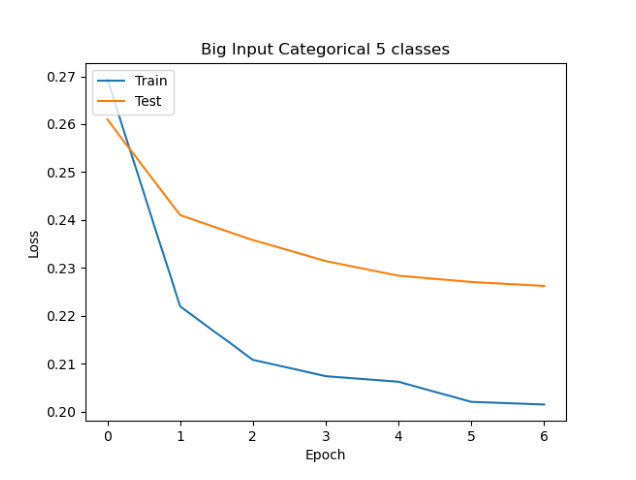

In [7]:
history_path = os.path.join(modelpath,MODELNAME+"_history.png")
figure(num=None, figsize=(10, 30), dpi=80, facecolor='w', edgecolor='k')
loss = np.array(Image.open(history_path))
plt.imshow(loss)
plt.axis('off')
plt.show()

x_transform = [Normalize(0.0033127920560417023,0.012673124326485102)]
y_transform = [cutOut([96,160,96,160]),LogBin()]

train,test = getData(BATCH_SIZE,
                         DIMENSION,CHANNELS,
                         timeToPred=30,
                         y_transform=y_transform,
                         x_transform=x_transform)

In [8]:
history_path = os.path.join(modelpath,MODELNAME+"_history")
laststate = getBestState(modelpath,history_path)
epoch = laststate["epoch"]
model.load_weights(laststate["modelpath"])
test.setWiggle_off()

In [11]:
def getFreshSet(batch_size=1):
    #x_transform = [Normalize(0.007742631458799244, 0.015872015890555563 )]
    
    train,test = getData(batch_size,
                         DIMENSION,CHANNELS,
                         timeToPred=30,
                         x_transform = x_transform,
                         y_transform=y_transform)
    return train,test

In [59]:
def categorical(t):
    return tfp.distributions.Independent(
            tfd.Categorical(logits=tf.math.log(t[...,:,:,:]))
            ,name="categorical",reinterpreted_batch_ndims=0 )

pred = None
label = None
pred = 20
test.on_epoch_end()
mean = []
stdev = []
label = []
predictions = []
train,test = getFreshSet(50)

test.setWiggle_off()
atm = []
for x,y in test:
    for i in range(BATCH_SIZE):
        if i < 10:
            continue
        if y.max() <= 5:
            continue
        pred = model(np.array([x[i,:,:,:]]))
        pred = categorical(pred)
        #p= 0
        p = np.arange(1,7)
        m = pred.prob(p)

        max_ = np.argmax(m[:,:,:,1:],axis=-1)


        m = pred.prob(0)
        mask = (m > 0.5)
        #print(mask.shape,max_.shape)
        #max_[mask] = 0
        
        mean.append(max_)
        #stdev.append(pred.sample())
        label.append(y[i,:,:,:])
        predictions.append((pred,y[i:,:,:]))
        atm.append(x[i,:,:,-1:])
        if len(label) == 20:
            break
    
    if len(label) == 20:
        break

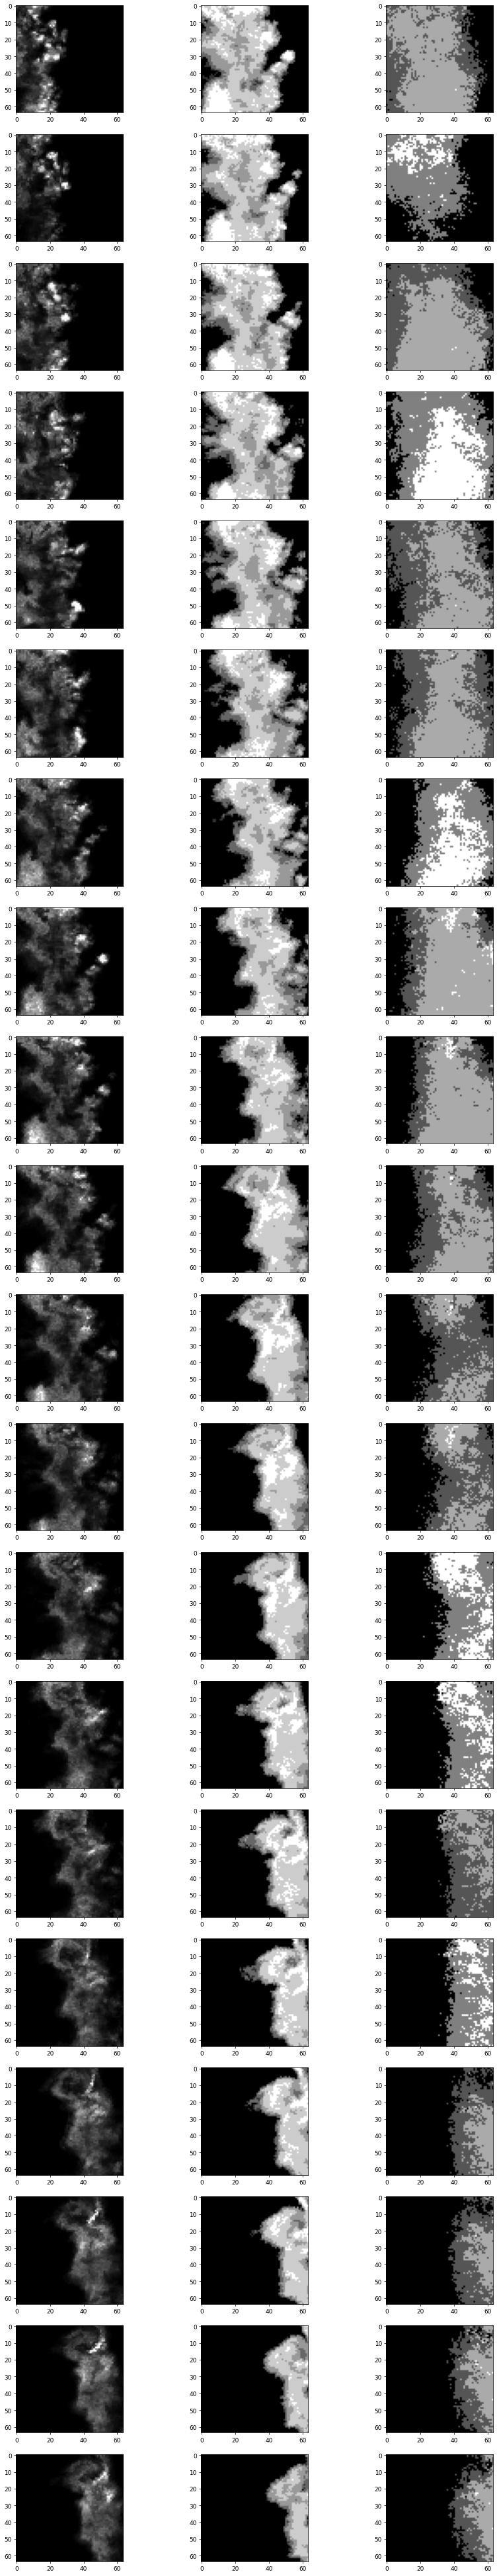

In [60]:
fig, axes = plt.subplots(20, 3, figsize=(16,8*10),dpi=64)
#fig.set_title(["mean","stdev","label"])
t = cutOut([96,160,96,160])
for batch,img in enumerate(mean):
    if batch == 20:
        break
    axes[batch,2].imshow(img[0,:,:],cmap="gray")
    #axes[batch,3].imshow(stdev[batch][0,:,:,0],cmap="gray")
    axes[batch,1].imshow(label[batch][:,:,0],cmap="gray")
    axes[batch,0].imshow(t(atm[batch][:,:,-1]),cmap="gray")
plt.show()

6
